In [131]:
import numpy as np
import matplotlib.pylab as plt
import math
import scipy.stats as sps
import scipy.optimize as opt
import pandas as pd
import seaborn as sns
import random

random.seed()
%matplotlib inline

# Линейная регрессия

# Задача 1

In [212]:
#подгружаем данные
data = pd.read_csv("forestfires.csv")

#таблица с индикатором летнего сезона и константой 1
indicator = pd.DataFrame({'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
                     'sesason': [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                     'constant': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

#соединим данные и таблицу с индикатором, тем самым избавимся от нечисленных значений и добавим константу 1 в таблицу
data = pd.merge(data, indicator, on='month')

#удалим ненужные колонки month и day
data.drop(['month', 'day'], axis=1, inplace=True)

#определим основные переменные
k = 0.7 #часть для вывода
N = len(data) #общее число строк
K = int(N * k) #число строк для обучающей выборки

При помощи метода наименьших квадратов найдём коэффициенты регрессионной модели. Будем пользоваться формулой МНК: $$\theta=(Z^TZ)^{-1}Z^TX.$$

In [198]:
def get_error(data, func=lambda x:x, inv_func=lambda x:x):
    #получаем выборки
    training = data[0:K]
    checking = data[K:N]
    training_points = func(np.array(training.pop('area')))
    checking_points = np.array(checking.pop('area'))
    training = np.array(training)
    checking = np.array(checking)
    
    #получаем коэффициенты МНК
    coefficients = np.linalg.inv(training.T @ training) @ training.T @ training_points

    #получаем предсказания площади пожара
    supposion = coefficients @ checking.T

    #выводим стреднеквадратичную ошибку
    return np.sqrt(sum((inv_func(supposion) - checking_points) ** 2) / (N - K))

Среднеквадратичное отклонение для непреобразованных данных

In [199]:
get_error(data.sample(frac=1))

66.502094951158583

Зависимость среднеквадратичного отклонения от константы $c$ в преобразованных данных по функции $f(x)=ln(x+c)$.

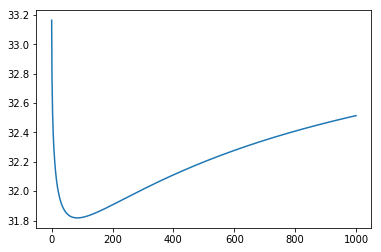

In [215]:
data_sample = data.sample(frac=1)

#функция ошибки при заданном c
def error_depend_on_c(c):
    return get_error(data_sample, lambda x: np.log(x+c), lambda x: np.exp(x) - c)
error_depend_on_c = np.vectorize(error_depend_on_c)

#построим график искомой зависимости
coordinates = np.linspace(0.1, 1000, 1000)
values = error_depend_on_c(coordinates)
plt.plot(coordinates, values)

In [216]:
#найдём минимальное значение ошибки
minimum = opt.minimize(error_depend_on_c, 0.1)
fun = minimum.fun
x = minimum.x

print("Минимальное значение среднеквадратичного отклонения на этой выборке достигается при c = ", x[0],
      " и равняется ", fun,
      ". Для сравнения, на этом же разбиении методом без преобразования отклонение равно ", get_error(data_sample))

Минимальное значение среднеквадратичного отклонения на этой выборке достигается при c =  84.2726337549  и равняется  31.81781467519083 . Для сравнения, на этом же разбиении методом без преобразования отклонение равно  33.4280679106


In [217]:
#зафиксируем c. Положим:
c_fixed = minimum.x

#выведем значения ошибки на разных разбиениях
for i in range(5):
    data_sample = data.sample(frac=1)
    print(get_error(data_sample, lambda x: np.log(x+c_fixed), lambda x: np.exp(x) - c_fixed))

65.1532015
87.8553981696
26.8240587551
107.054688969
90.4556118917


### Вывод
Оба метода, с применением преобразования и без него, показывают на одних и тех же разбиениях почти одинаковые откланения. Линейная регрессия показывает себя плохо в этой задаче, так как средняя площадь пожара по всем данным равна 13, а отклонение часто существенно превышает 30. Также качество оценки сильно зависит от разбиения. Из этого можно сделать вывод, что площадь пожара не зависит линейно от предложенных параметров.